C:\Users\nicar\AppData\Local\Temp\ipykernel_29104\2368744499.py:66: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "bo-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(cluster_range, wcss_kmeans, 'bo-', label="K-Means WCSS", linestyle="dashed")
C:\Users\nicar\AppData\Local\Temp\ipykernel_29104\2368744499.py:67: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "go-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(cluster_range, wcss_hierarchical, 'go-', label="Hierarchical WCSS", linestyle="dashed")
C:\Users\nicar\AppData\Local\Temp\ipykernel_29104\2368744499.py:68: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "mo-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(cluster_range, wcss_cosine, 'mo-', label="Cosine Similarity WCSS", linestyle="dashed")
C

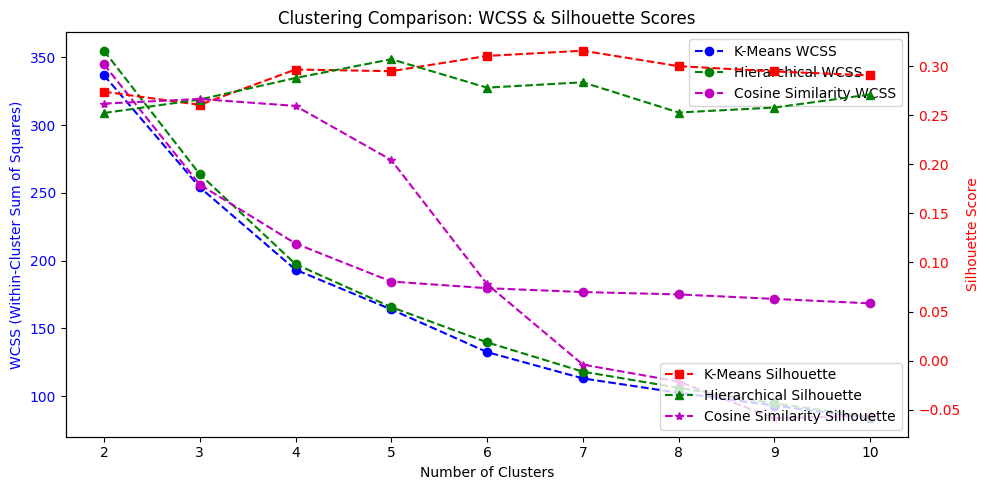

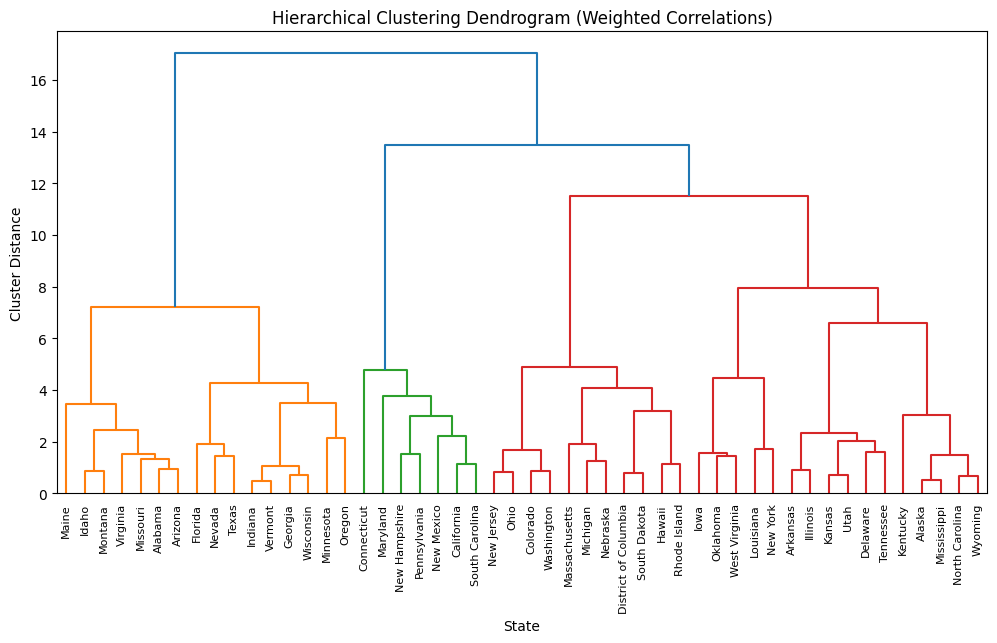

Weighted Clustering Completed. Results saved to 'data/weighted_clustering_results.csv'.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler

# --- Load Weighted Correlation Data ---
file_path = "data/notable_state_correlation_trends_filtered.csv"  # Ensure correct file path
df = pd.read_csv(file_path)

# --- Prepare Data for Clustering ---
df_pivot = df.pivot(index='State', columns=['Metric 1', 'Metric 2'], values='Correlation').fillna(0)
X = df_pivot.to_numpy()

# Standardize features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Perform Clustering for Multiple Cluster Counts ---
cluster_range = list(range(2, 11))
wcss_kmeans = []  # WCSS for K-Means
wcss_hierarchical = []  # WCSS for Hierarchical
wcss_cosine = []  # WCSS for Cosine

silhouette_kmeans = []
silhouette_hierarchical = []
silhouette_cosine = []

for n_clusters in cluster_range:
    # K-Means Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    wcss_kmeans.append(kmeans.inertia_)  # Correct WCSS calculation for K-Means
    silhouette_kmeans.append(silhouette_score(X_scaled, kmeans_labels))
    
    # Hierarchical Clustering
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    hierarchical_labels = hierarchical.fit_predict(X_scaled)
    
    # Compute WCSS for Hierarchical by summing squared distances to centroids
    cluster_centroids = np.array([X_scaled[hierarchical_labels == i].mean(axis=0) for i in range(n_clusters)])
    cluster_distances = np.array([np.sum((X_scaled[hierarchical_labels == i] - cluster_centroids[i]) ** 2) for i in range(n_clusters)])
    wcss_hierarchical.append(np.sum(cluster_distances))

    silhouette_hierarchical.append(silhouette_score(X_scaled, hierarchical_labels))

    # Cosine Similarity Clustering (Precomputed Distance)
    cosine_distance = 1 - np.dot(X_scaled, X_scaled.T)  # Cosine distance
    cosine_hc = AgglomerativeClustering(n_clusters=n_clusters, metric="precomputed", linkage="average")
    cosine_labels = cosine_hc.fit_predict(cosine_distance)
    
    # Compute WCSS for Cosine Similarity by summing squared cosine distances to centroids
    cluster_centroids_cosine = np.array([X_scaled[cosine_labels == i].mean(axis=0) for i in range(n_clusters)])
    cluster_distances_cosine = np.array([np.sum((X_scaled[cosine_labels == i] - cluster_centroids_cosine[i]) ** 2) for i in range(n_clusters)])
    wcss_cosine.append(np.sum(cluster_distances_cosine))

    silhouette_cosine.append(silhouette_score(X_scaled, cosine_labels))

# --- Plot WCSS & Silhouette Score for All Methods ---
fig, ax1 = plt.subplots(figsize=(10, 5))

# WCSS (Elbow) on Left Y-Axis
ax1.plot(cluster_range, wcss_kmeans, 'bo-', label="K-Means WCSS", linestyle="dashed")
ax1.plot(cluster_range, wcss_hierarchical, 'go-', label="Hierarchical WCSS", linestyle="dashed")
ax1.plot(cluster_range, wcss_cosine, 'mo-', label="Cosine Similarity WCSS", linestyle="dashed")
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("WCSS (Within-Cluster Sum of Squares)", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# Silhouette Scores on Right Y-Axis
ax2 = ax1.twinx()
ax2.plot(cluster_range, silhouette_kmeans, 'rs-', label="K-Means Silhouette", linestyle="dashed")
ax2.plot(cluster_range, silhouette_hierarchical, 'g^-', label="Hierarchical Silhouette", linestyle="dashed")
ax2.plot(cluster_range, silhouette_cosine, 'm*-', label="Cosine Similarity Silhouette", linestyle="dashed")
ax2.set_ylabel("Silhouette Score", color="red")
ax2.tick_params(axis='y', labelcolor="red")

# Legends
ax1.legend(loc="upper right")
ax2.legend(loc="lower right")
plt.title("Clustering Comparison: WCSS & Silhouette Scores")
fig.tight_layout()
plt.show()

# --- Dendrogram for Hierarchical Clustering ---
plt.figure(figsize=(12, 6))
linkage_matrix = sch.linkage(X_scaled, method="ward")
sch.dendrogram(linkage_matrix, labels=df_pivot.index, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram (Weighted Correlations)")
plt.xlabel("State")
plt.ylabel("Cluster Distance")
plt.show()

# --- Save Final Clustering Results ---
df_pivot['KMeans Cluster'] = kmeans_labels
df_pivot['Hierarchical Cluster'] = hierarchical_labels
df_pivot['Cosine Cluster'] = cosine_labels
df_pivot.reset_index(inplace=True)
df_pivot[['State', 'KMeans Cluster', 'Hierarchical Cluster', 'Cosine Cluster']].to_csv("data/weighted_clustering_results.csv", index=False)

print("Weighted Clustering Completed. Results saved to 'data/weighted_clustering_results.csv'.")



In [2]:
# --- Identify Missing States at Each Stage ---
print("\nChecking for missing states during clustering...")

# Load original cleaned dataset
df_cleaned = pd.read_csv("data/cleaned_multiple_cause_of_death.csv")
original_states = set(df_cleaned["State"].unique())

# Load states after correlation filtering
df_corr_filtered = pd.read_csv("data/notable_state_correlation_trends_filtered.csv")
correlation_states = set(df_corr_filtered["State"].unique())

# Load states from final clustering results
df_clustered = pd.read_csv("data/weighted_clustering_results.csv")
clustered_states = set(df_clustered["State"].unique())

# Identify missing states at each stage
missing_after_correlation = original_states - correlation_states
missing_after_clustering = correlation_states - clustered_states

# Print missing states at each stage
if missing_after_correlation:
    print("States missing after correlation filtering:")
    print(", ".join(sorted(missing_after_correlation)))
else:
    print("No states were lost after correlation filtering.")

if missing_after_clustering:
    print("States missing after clustering:")
    print(", ".join(sorted(missing_after_clustering)))
else:
    print("No states were lost after clustering.")

print("\nClustering process completed successfully!")



Checking for missing states during clustering...
States missing after correlation filtering:
North Dakota
No states were lost after clustering.

Clustering process completed successfully!
